In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cmath

In [14]:
def load_object_from_pkl(filename):
    """
    Load an object from a .pkl file using pickle.
    
    Parameters:
        filename (str): The name of the .pkl file.
    
    Returns:
        object: The loaded object from the .pkl file.
    """
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    print(f"Object loaded from {filename}")
    return obj

def analyze_stirap_data(pkl_path, len_list):
    data_sinsquare = load_object_from_pkl(pkl_path)
    data_full = [data_sinsquare]
    full_analysis_data = []

    for data_a_0 in data_full:
        n_ph_e, n_ph_l, n_ph_t = [], [], []
        n_err_e, n_err_l, n_err_t = [], [], []
        scattering_e, scattering_l, scattering_total = [], [], []
        error_emission_e, error_emission_l, error_emission_total = [], [], []

        for i in range(len(len_list)):
            idx_even = 2 * i
            idx_odd = 2 * i + 1

            n_ph_e.append(data_a_0[idx_even][6])
            n_ph_l.append(data_a_0[idx_odd][6])
            n_ph_t.append(data_a_0[idx_even][6] + data_a_0[idx_odd][6])

            n_err_e.append(data_a_0[idx_even][4])
            n_err_l.append(data_a_0[idx_odd][4])
            n_err_t.append(data_a_0[idx_even][4] + data_a_0[idx_odd][4])

            scattering_e.append(data_a_0[idx_even][3])
            scattering_l.append(data_a_0[idx_odd][3])
            scattering_total.append(data_a_0[idx_even][3] + data_a_0[idx_odd][3])

            error_emission_e.append(data_a_0[idx_even][5])
            error_emission_l.append(data_a_0[idx_odd][5])
            error_emission_total.append(data_a_0[idx_even][5] + data_a_0[idx_odd][5])

        full_analysis_data.append([
            n_ph_e, n_ph_l, n_ph_t,
            scattering_e, scattering_l, scattering_total,
            n_err_e, n_err_l, n_err_t,
            error_emission_e, error_emission_l, error_emission_total
        ])

    return full_analysis_data

In [15]:
def create_pulse(_time_array, _pulse_fct, _pulse_amp):
    """
    Creates an array of amplitudes for a laser pulse
    Args:
        _time_array: array of time points over which to calculate the laser amplitude
        _pulse_fct: function governing the laser amplitude at each time step
        _pulse_amp: float scaling the overall amplitude of the pulse
    Returns:
        pulse_array: array of laser amplitudes
    """
    pulse_array = np.zeros(len(_time_array))
    for i in range(len(_time_array)):
        pulse_array[i] = _pulse_amp*_pulse_fct(_time_array[i],_time_array[-1])

    return pulse_array

def create_single_blackman(time_array, laser_amp):
    """
    Creates a single Blackman pulse using the create_pulse function.
    Args:
        time_array: array of time points over which to calculate the laser amplitude
        laser_amp: amplitude of the laser
    Returns:
        laser_array: array of amplitudes
    """
    # Define the Blackman function as a lambda function
    blackman_fct = lambda t, T: 0.42 - 0.5 * np.cos(
        2 * np.pi * t / T) + 0.08 * np.cos(4 * np.pi * t / T)

    # Use create_pulse to apply the function over the time array
    laser_array = create_pulse(time_array, blackman_fct, laser_amp)

    return laser_array

def create_flattop_gaussian(time_array, laser_amp, ramp_up_time, ramp_down_time):
    """
    Creates a single flattop pulse with a gaussian ramp up and down
    Args:
        time_array: array of time points over which to calculate the laser amplitude
        laser_amp: amplitude of the laser
        ramp_time: time over which the ramp up and down occur
    Returns:
        laser_array: array of amplitudes
    """

    if ramp_up_time + ramp_down_time < time_array[-1]:
        AssertionError("Ramp up and down time is greater than total time")

    # Define the flattop function as a lambda function
    #picked a sigma of 4 to ensure the pulse starts at zero
    def flattop_fct(t, T):
        if t < ramp_up_time:
            return np.exp(-0.5 * ((t - ramp_up_time) / (ramp_up_time / 4))**2)
        elif t > T - ramp_down_time:
            return np.exp(-0.5 * ((t - (T - ramp_down_time)) / (ramp_down_time / 4))**2)
        else:
            return 1

    # Use create_pulse to apply the function over the time array
    laser_array = create_pulse(time_array, flattop_fct, laser_amp)

    return laser_array


def create_flattop_blackman(time_array, laser_amp, ramp_up_time, ramp_down_time):
    """
    Creates a single flattop pulse with a Blackman ramp up and down.
    Args:
        time_array: array of time points over which to calculate the laser amplitude
        laser_amp: amplitude of the laser
        ramp_time: time over which the ramp up and down occur
    Returns:
        laser_array: array of amplitudes
    """
    #assert ramp time is less total time
    if ramp_up_time + ramp_down_time < time_array[-1]:
        AssertionError("Ramp up and down time is greater than total time")

    T = time_array[-1]  # Total duration of the pulse
    
    # Define the Blackman ramp-up and ramp-down function
    def flattop_fct(t, T):
        if t < ramp_up_time:  # Ramp up
            return 0.42 - 0.5 * np.cos(2 * np.pi * t / (2 * ramp_up_time)) + \
                   0.08 * np.cos(4 * np.pi * t / (2 * ramp_up_time))
        elif t > T - ramp_down_time:  # Ramp down
            t_ramp = T - t
            return 0.42 - 0.5 * np.cos(2 * np.pi * t_ramp / (2 * ramp_down_time)) + \
                   0.08 * np.cos(4 * np.pi * t_ramp / (2 * ramp_down_time))
        else:  # Flattop region
            return 1

    # Apply the flattop function to the time array
    laser_array = np.array([laser_amp * flattop_fct(t, T) for t in time_array])

    return laser_array

SinSquared Pulse

In [3]:
len_list=np.linspace(0.1,2,50)

full_analysis_data=analyze_stirap_data("vstirap_length_rate/mc/pulse_shape_sinsquared_fine_lensweep_omegaL:30.0.pkl", len_list)

Object loaded from vstirap_length_rate/mc/pulse_shape_sinsquared_fine_lensweep_omegaL:30.0.pkl


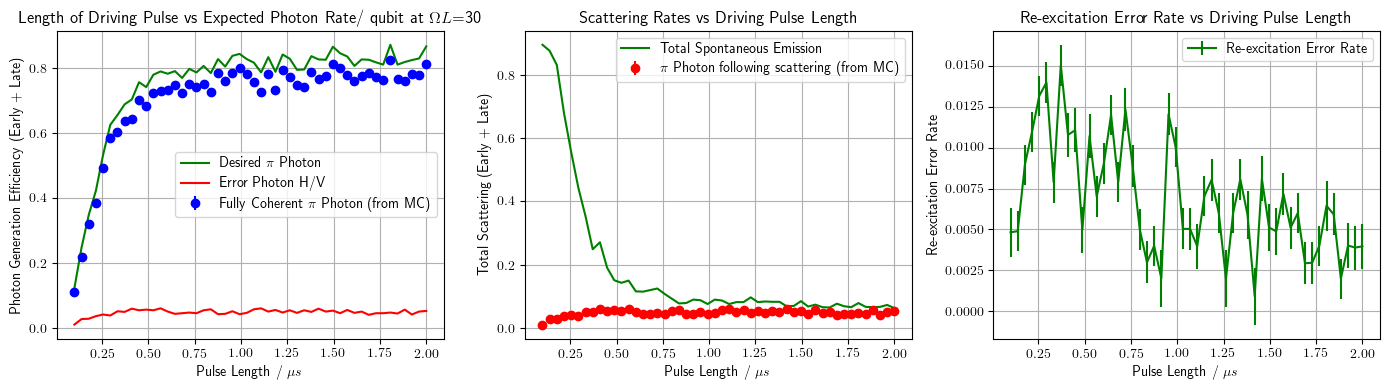

In [4]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000

# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(len_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
axs[0].errorbar(len_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
axs[0].plot(len_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
axs[0].legend()
axs[0].set_title(f'Length of Driving Pulse vs Expected Photon Rate/ qubit at $\Omega L$=30')
axs[0].set_xlabel('Pulse Length / $\mu s$')
axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_errors = np.array([full_analysis_data[0][9]]) * (1 / n_trajectories)
#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(len_list, np.array(full_analysis_data[0][3])+np.array(full_analysis_data[0][4]), color='g', label="Total Spontaneous Emission")
axs[1].errorbar(len_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length')
axs[1].set_xlabel('Pulse Length / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories  # e.g., 5%

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

axs[2].errorbar(len_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length')
axs[2].set_xlabel('Pulse Length / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/length_vs_photon_generation_MC_sinsquared.pdf')

In [ ]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000

# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(pulse_time, pulse_1, color='g', label='Driving Pulse Shape')
#axs[0].errorbar(len_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
#axs[0].plot(len_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
#axs[0].legend()
axs[0].set_title(f'Shape of V-STIRAP Driving Pulse')
axs[0].set_xlabel('Pulse Length / a.u.$')
#axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_errors = np.array([full_analysis_data[0][9]]) * (1 / n_trajectories)
#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(len_list,
            np.array(full_analysis_data[0][3]) +
            np.array(full_analysis_data[0][4]),
            color='g',
            label="Total Spontaneous Emission")
axs[1].plot(len_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[1].errorbar(len_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length  for $\Omega L$=30')
axs[1].set_xlabel('Pulse Length / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories  # e.g., 5%

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

axs[2].errorbar(len_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length for $\Omega L$=30')
axs[2].set_xlabel('Pulse Length / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/length_vs_photon_generation_MC_sinsquared.pdf')

Gaussian Square Pulse

In [5]:

len_list=np.linspace(0.1,2,50)

full_analysis_data=analyze_stirap_data("vstirap_length_rate/mc/pulse_shape_flattop_gaussian_fine_lensweep_omegaL:30.0.pkl", len_list)

Object loaded from vstirap_length_rate/mc/pulse_shape_flattop_gaussian_fine_lensweep_omegaL:30.0.pkl


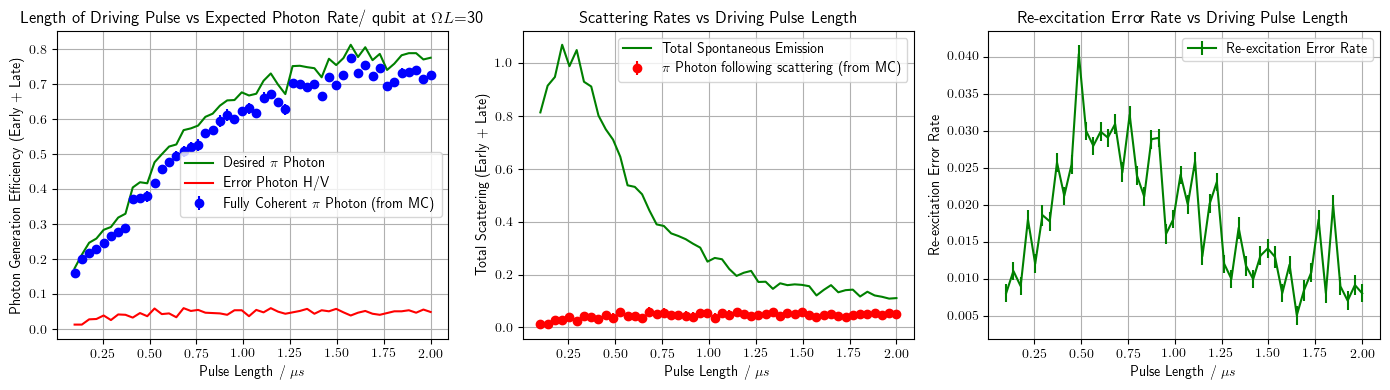

In [6]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000
# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(len_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
axs[0].errorbar(len_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
axs[0].plot(len_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
axs[0].legend()
axs[0].set_title(f'Length of Driving Pulse vs Expected Photon Rate/ qubit at $\Omega L$=30')
axs[0].set_xlabel('Pulse Length / $\mu s$')
axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_errors=np.array(full_analysis_data[0][2])*err_MC

#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(len_list, np.array(full_analysis_data[0][3])+np.array(full_analysis_data[0][4]), color='g', label="Total Spontaneous Emission")
axs[1].errorbar(len_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length')
axs[1].set_xlabel('Pulse Length / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories  # e.g., 5%

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

axs[2].errorbar(len_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length')
axs[2].set_xlabel('Pulse Length / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/length_vs_photon_generation_MC_square.pdf')

Blackman Ramp

In [4]:
len_list=np.linspace(0.1,2,50)

full_analysis_data=analyze_stirap_data("vstirap_length_rate/mc/pulse_shape_blackman_fine_lensweep_omegaL:30.0.pkl", len_list)

Object loaded from vstirap_length_rate/mc/pulse_shape_blackman_fine_lensweep_omegaL:30.0.pkl


[0.0012371791482634837, 0.0012250675099059567, 0.0012680057085027454, 0.0012428281929883237, 0.0014663396023816837, 0.001249539336513561, 0.001253362084148, 0.00122474979966473, 0.001238053090538068, 0.0012248478749164221, 0.0012392075364956222, 0.001246176771037712, 0.0013021800751948991, 0.0015371352151709017, 0.0013847330882578454, 0.00122631839786029, 0.0012303809459280708, 0.0012430831316386736, 0.0012653033472943278, 0.0013962401363989162, 0.0012591435286013278, 0.0012730476975969115, 0.0015471846551315944, 0.001242908115895318, 0.0012525211547281838, 0.0012299768989679446, 0.0012253530656708574, 0.001225376888720917, 0.0017320508075688772, 0.001239832191595534, 0.0012501765183432253, 0.0012500747414545756, 0.0012347518151324453, 0.0012315907330997075, 0.001317119219817228, 0.0012760226478584938, 0.0012657546145233012, 0.0012455638443583808, 0.0012319815346351353, 0.0012249937125077479, 0.0014572766174968696, 0.0017320508075688772, 0.001225421495500245, 0.0012338866240293458, 0.0

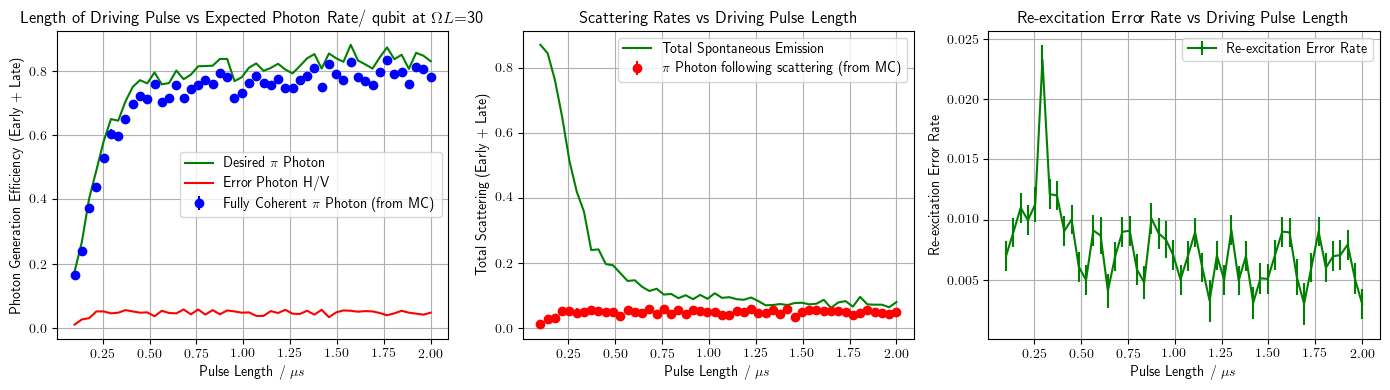

<Figure size 640x480 with 0 Axes>

In [5]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000
# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(len_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
axs[0].errorbar(len_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
axs[0].plot(len_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
axs[0].legend()
axs[0].set_title(f'Length of Driving Pulse vs Expected Photon Rate/ qubit at $\Omega L$=30')
axs[0].set_xlabel('Pulse Length / $\mu s$')
axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_errors=np.array(full_analysis_data[0][2])*err_MC

#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(len_list, np.array(full_analysis_data[0][3])+np.array(full_analysis_data[0][4]), color='g', label="Total Spontaneous Emission")
axs[1].errorbar(len_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length')
axs[1].set_xlabel('Pulse Length / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories  # e.g., 5%

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

print(false_emission_fraction_errors)

axs[2].errorbar(len_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length')
axs[2].set_xlabel('Pulse Length / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/length_vs_photon_generation_MC_blackman.pdf')

Flattop Blackman Ramp

In [6]:
len_list=np.linspace(0.1,2,50)

full_analysis_data=analyze_stirap_data("vstirap_length_rate/mc/pulse_shape_flattop_blackman_fine_lensweep_omegaL:30.0.pkl", len_list)

Object loaded from vstirap_length_rate/mc/pulse_shape_flattop_blackman_fine_lensweep_omegaL:30.0.pkl


[0.0012443639009267178, 0.0013393150524077788, 0.0012303764511350471, 0.001224744871391589, 0.0013910108707711633, 0.0012562656663569654, 0.0012379976793696623, 0.0012275610525270745, 0.001240679684140036, 0.001275864564203835, 0.001226954480444374, 0.0012814212958422797, 0.0012252955881599775, 0.0012301766943498202, 0.0012519154419760614, 0.0012332971870010175, 0.0013351227489110833, 0.0012299740968635892, 0.001241766647083635, 0.001381709009501408, 0.0013895743579702934, 0.0012311891228081015, 0.0012249464463402813, 0.0012829809841004064, 0.0013383133125420387, 0.001385370120868574, 0.001235995952311648, 0.0012344554035023934, 0.001318110763542673, 0.0012566062158689318, 0.0012970935700668735, 0.0012248833613608722, 0.001240104296428423, 0.0012322818340454907, 0.0012400165814715482, 0.0012289123071332101, 0.0013074235335972326, 0.0012377754658512276, 0.0012402361514223825, 0.0012373050358946147, 0.0012381566279132867, 0.0012256520659214682, 0.001417985470083144, 0.0013886711035978254

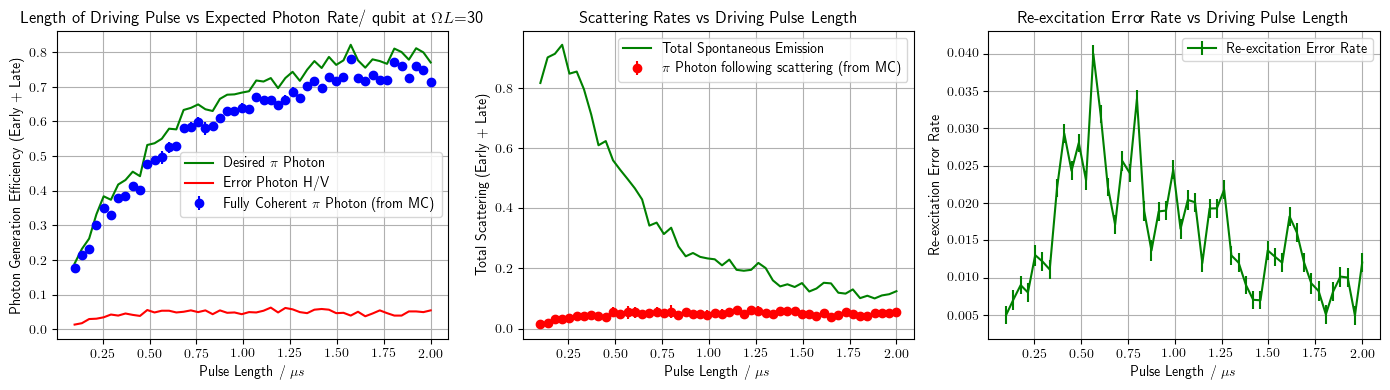

<Figure size 640x480 with 0 Axes>

In [7]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000
# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(len_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
axs[0].errorbar(len_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
axs[0].plot(len_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
axs[0].legend()
axs[0].set_title(f'Length of Driving Pulse vs Expected Photon Rate/ qubit at $\Omega L$=30')
axs[0].set_xlabel('Pulse Length / $\mu s$')
axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_errors=np.array(full_analysis_data[0][2])*err_MC

#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(len_list, np.array(full_analysis_data[0][3])+np.array(full_analysis_data[0][4]), color='g', label="Total Spontaneous Emission")
axs[1].errorbar(len_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length')
axs[1].set_xlabel('Pulse Length / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories  # e.g., 5%

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

print(false_emission_fraction_errors)

axs[2].errorbar(len_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length')
axs[2].set_xlabel('Pulse Length / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/length_vs_photon_generation_MC_flattop_blackman.pdf')

analyse risetime

In [20]:
rise_time_list=np.linspace(0.05,0.75,30)

full_analysis_data=analyze_stirap_data("vstirap_length_rate/mc/pulse_shape_flattop_blackman_risetime_sweep_omegaL:30.0_moredata.pkl", rise_time_list)

Object loaded from vstirap_length_rate/mc/pulse_shape_flattop_blackman_risetime_sweep_omegaL:30.0_moredata.pkl


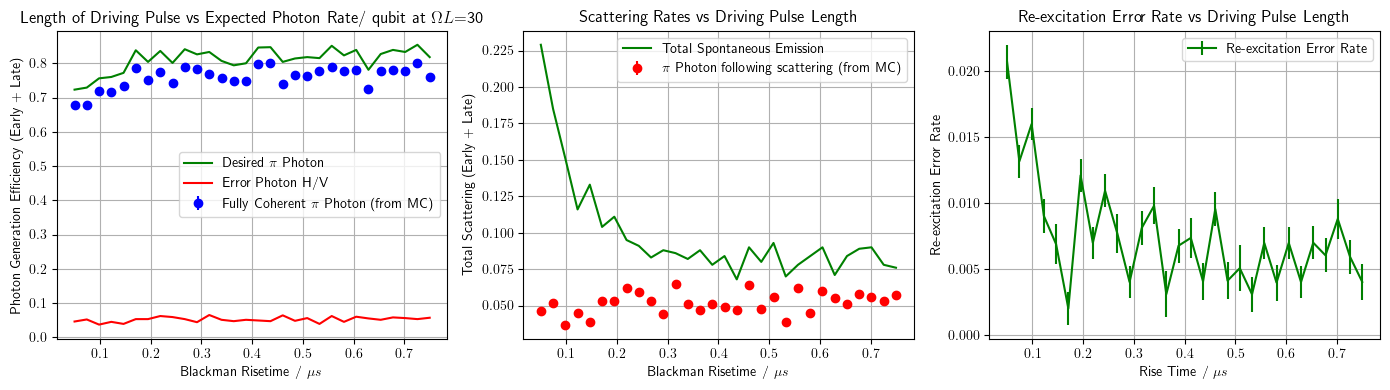

In [21]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000

# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(rise_time_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
axs[0].errorbar(rise_time_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
axs[0].plot(rise_time_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
axs[0].legend()
axs[0].set_title(f'Length of Driving Pulse vs Expected Photon Rate/ qubit at $\Omega L$=30')
axs[0].set_xlabel('Blackman Risetime / $\mu s$')
axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_fraction_errors = np.array([
    full_analysis_data[0][2][i] + full_analysis_data[0][9][i]
    for i in range(len(full_analysis_data[0][2]))
]) * (1 / n_trajectories)
false_emission_errors = np.array([full_analysis_data[0][9]]) * (1 / n_trajectories)

#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(rise_time_list, np.array(full_analysis_data[0][3])+np.array(full_analysis_data[0][4]), color='g', label="Total Spontaneous Emission")
axs[1].errorbar(rise_time_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length')
axs[1].set_xlabel('Blackman Risetime / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories  # e.g., 5%

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

axs[2].errorbar(rise_time_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length')
axs[2].set_xlabel('Rise Time / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/risetime_vs_photon_generation_MC_flattop_blackman_omegaL=30.pdf')

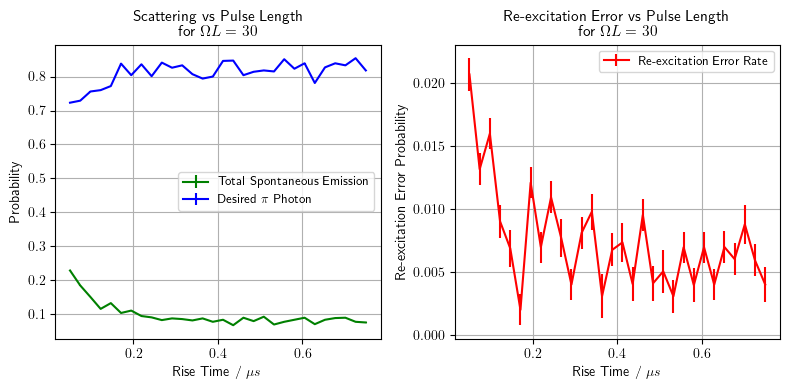

In [24]:
# Enable LaTeX text rendering
plt.rcParams['text.usetex'] = True

# Pulse length range and dummy data access
len_list = np.linspace(0.1, 2, 50)
omegaL_str = "30"
n_trajectories = 1000

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Get relevant data
useful_emissions = np.array(full_analysis_data[0][2]) - np.array(full_analysis_data[0][9])
err_MC = np.array(full_analysis_data[0][8])
useful_errors = useful_emissions * err_MC

# --- Panel 1: Spontaneous Emission and Desired π Photon ---
total_spont = np.array(full_analysis_data[0][3]) + np.array(full_analysis_data[0][4])
desired_pi = np.array(full_analysis_data[0][2])
total_spont_err = total_spont / n_trajectories
desired_pi_err = desired_pi / n_trajectories

axs[0].errorbar(rise_time_list, total_spont, yerr=total_spont_err, color='g', label="Total Spontaneous Emission")
axs[0].errorbar(rise_time_list, desired_pi, yerr=desired_pi_err, color='b', label='Desired $\pi$ Photon')

axs[0].legend(fontsize=9)
axs[0].set_title(f'Scattering vs Pulse Length\nfor $\\Omega L = {omegaL_str}$', fontsize=11)
axs[0].set_xlabel('Rise Time / $\mu s$')
axs[0].set_ylabel('Probability')
axs[0].grid(True)

# --- Panel 2: Re-excitation Error Rate ---
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Re-excitation error and uncertainties
total_reexcitation = [a[i]/b[i]*c[i] + d[i]/c[i]*b[i] for i in range(len(d))]
epsilon = 1 / n_trajectories
rel_errors = [
    np.sqrt(3) * np.sqrt((a[i] / b[i] * c[i])**2 + (d[i] / c[i] * b[i])**2) / total_reexcitation[i] * epsilon
    for i in range(len(d))
]

axs[1].errorbar(rise_time_list, total_reexcitation, yerr=rel_errors, color='r', label='Re-excitation Error Rate')
axs[1].legend(fontsize=9)
axs[1].set_title(f'Re-excitation Error vs Pulse Length\nfor $\\Omega L = {omegaL_str}$', fontsize=11)
axs[1].set_xlabel('Rise Time / $\mu s$')
axs[1].set_ylabel('Re-excitation Error Probability')
axs[1].grid(True)

# Final layout adjustments
plt.tight_layout()
plt.show()



more lengths and omegaL=50

In [52]:
rise_time_list=np.linspace(0.05,0.75,15)

full_analysis_data=analyze_stirap_data("vstirap_length_rate/mc/pulse_shape_flattop_blackman_risetime_sweep_omegaL:50.0_5ktraj.pkl", rise_time_list)

Object loaded from vstirap_length_rate/mc/pulse_shape_flattop_blackman_risetime_sweep_omegaL:50.0_5ktraj.pkl


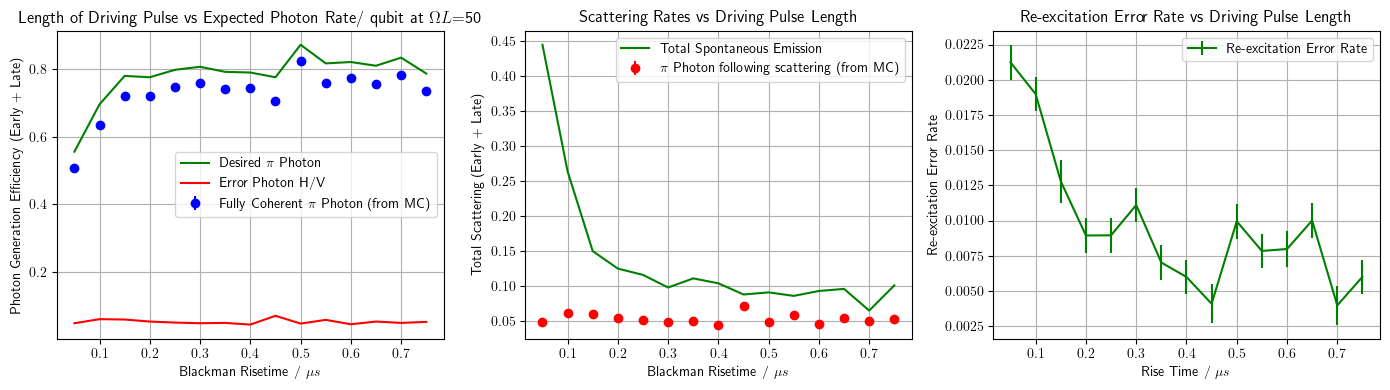

In [53]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000

# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(rise_time_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
axs[0].errorbar(rise_time_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
axs[0].plot(rise_time_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
axs[0].legend()
axs[0].set_title(f'Length of Driving Pulse vs Expected Photon Rate/ qubit at $\Omega L$=50')
axs[0].set_xlabel('Blackman Risetime / $\mu s$')
axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_fraction_errors = np.array([
    full_analysis_data[0][2][i] + full_analysis_data[0][9][i]
    for i in range(len(full_analysis_data[0][2]))
]) * (1 / n_trajectories)
false_emission_errors = np.array([full_analysis_data[0][9]]) * (1 / n_trajectories)

#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(rise_time_list, np.array(full_analysis_data[0][3])+np.array(full_analysis_data[0][4]), color='g', label="Total Spontaneous Emission")
axs[1].errorbar(rise_time_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length')
axs[1].set_xlabel('Blackman Risetime / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories 

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

axs[2].errorbar(rise_time_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length')
axs[2].set_xlabel('Rise Time / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/risetime_vs_photon_generation_MC_flattop_blackman_omegaL=50.pdf')

In [55]:
rise_time_list=np.linspace(0.05,0.75,15)

full_analysis_data=analyze_stirap_data("vstirap_length_rate/mc/pulse_shape_flattop_blackman_risetime_sweep_omegaL:40.0.pkl", rise_time_list)

Object loaded from vstirap_length_rate/mc/pulse_shape_flattop_blackman_risetime_sweep_omegaL:40.0.pkl


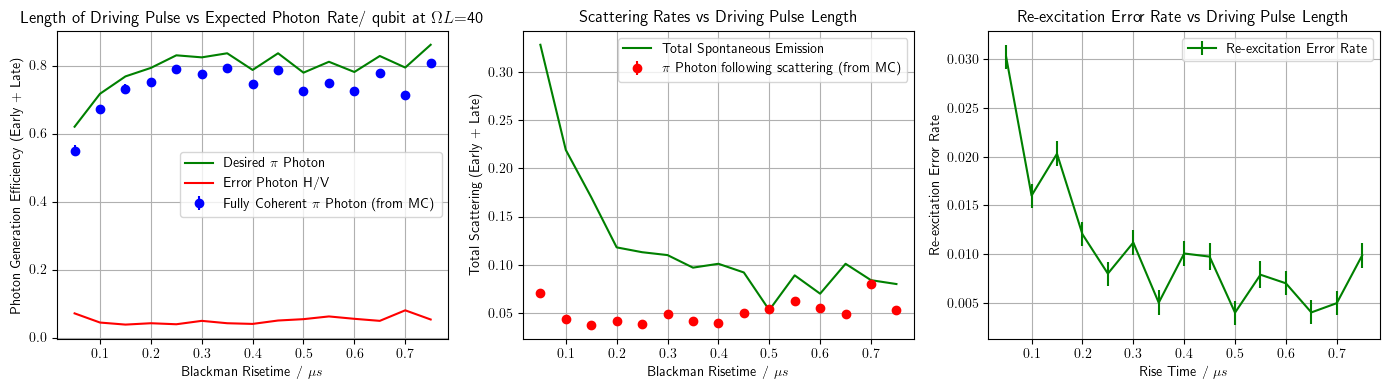

In [56]:
# Create figure and axes
plt.rcParams['text.usetex'] = True
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

n_trajectories=1000

# Plot data
useful_emissions=np.array(full_analysis_data[0][2])-np.array(full_analysis_data[0][9])
err_MC=np.array(full_analysis_data[0][8])
useful_errors=useful_emissions*err_MC

axs[0].plot(rise_time_list, full_analysis_data[0][2], color='g', label='Desired $\pi$ Photon')
axs[0].errorbar(rise_time_list, useful_emissions, yerr=useful_errors, color='b', fmt='o', label='Fully Coherent $\pi$ Photon (from MC)')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][1], color='g', label='MC Pi Photon')
#axs[i, 0].plot(len_list_MC, full_data_MC[area_indexes[i]][0], color='c', label='MC H/V Photon')
axs[0].plot(rise_time_list, full_analysis_data[0][9], color='r', label='Error Photon H/V')
axs[0].legend()
axs[0].set_title(f'Length of Driving Pulse vs Expected Photon Rate/ qubit at $\Omega L$=40')
axs[0].set_xlabel('Blackman Risetime / $\mu s$')
axs[0].set_ylabel('Photon Generation Efficiency (Early + Late)')
axs[0].grid(True)

false_emission_fraction_errors = np.array([
    full_analysis_data[0][2][i] + full_analysis_data[0][9][i]
    for i in range(len(full_analysis_data[0][2]))
]) * (1 / n_trajectories)
false_emission_errors = np.array([full_analysis_data[0][9]]) * (1 / n_trajectories)

#axs[1].plot(len_list, np.array(full_analysis_data[0][5])+np.array(full_analysis_data[0][6]), color='b' , label="Spontaneous Emission to initial state")
axs[1].plot(rise_time_list, np.array(full_analysis_data[0][3])+np.array(full_analysis_data[0][4]), color='g', label="Total Spontaneous Emission")
axs[1].errorbar(rise_time_list, full_analysis_data[0][9], yerr=false_emission_errors,color='r',fmt='o', label='$\pi$ Photon following scattering (from MC)')

axs[1].legend()
axs[1].set_title('Scattering Rates vs Driving Pulse Length')
axs[1].set_xlabel('Blackman Risetime / $\mu s$')
axs[1].set_ylabel('Total Scattering (Early + Late)')
axs[1].grid(True)

total_reexcitation_errors = [full_analysis_data[0][6][i] / full_analysis_data[0][0][i]*full_analysis_data[0][1][i]+
                            full_analysis_data[0][7][i] / full_analysis_data[0][1][i]*full_analysis_data[0][0][i] for i in range(len(full_analysis_data[0][7]))]

# Example value for fractional error
epsilon = 1/n_trajectories  # e.g., 5%

# Unpack columns for readability
a = full_analysis_data[0][6]
b = full_analysis_data[0][0]
c = full_analysis_data[0][1]
d = full_analysis_data[0][7]

# Compute total reexcitation values and their relative errors
false_emission_fraction_errors = []
for i in range(len(d)):
    f1 = a[i] / b[i] * c[i]
    f2 = d[i] / c[i] * b[i]
    f = f1 + f2
    rel_error = np.sqrt(3) * np.sqrt(f1**2 + f2**2) / f * epsilon
    false_emission_fraction_errors.append(rel_error)

axs[2].errorbar(rise_time_list, total_reexcitation_errors,
 yerr=false_emission_fraction_errors,
            color='g',
            label='Re-excitation Error Rate')
axs[2].legend()
axs[2].set_title('Re-excitation Error Rate vs Driving Pulse Length')
axs[2].set_xlabel('Rise Time / $\mu s$')
axs[2].set_ylabel('Re-excitation Error Rate')
axs[2].grid(True)


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

fig.savefig('pdf_figs/risetime_vs_photon_generation_MC_flattop_blackman_omegaL=40.pdf')

In [18]:
def plot_stirap_analysis(axs_row,
                         full_analysis_data,
                         len_list,
                         pulse_time,
                         pulse_1,
                         omegaL_str,
                         n_trajectories=1000):
    # Panel 1: Driving Pulse Shape
    axs_row[0].plot(pulse_time,
                    pulse_1,
                    color='g',
                    label='Driving Pulse Shape')
    axs_row[0].set_title('Shape of V-STIRAP Driving Pulse')
    axs_row[0].set_xlabel('Pulse Length / a.u.')
    axs_row[0].set_ylabel('Amplitude / a.u.')
    axs_row[0].grid(True)

    # Panel 2: Spontaneous Emission with fractional error bars
    total_spont = np.array(full_analysis_data[0][3]) + np.array(
        full_analysis_data[0][4])
    desired_pi = np.array(full_analysis_data[0][2])

    total_spont_err = 2 / 1000
    desired_pi_err = 2 / 1000

    axs_row[1].errorbar(len_list,
                        total_spont,
                        yerr=total_spont_err,
                        color='g',
                        label="Total Spontaneous Emission")
    axs_row[1].errorbar(len_list,
                        desired_pi,
                        yerr=desired_pi_err,
                        color='b',
                        label='Desired $\pi$ Photon')

    axs_row[1].legend(fontsize=9)
    axs_row[1].set_title(f'Scattering vs Length, $\Omega L$={omegaL_str}',
                         fontsize=11)
    axs_row[1].set_xlabel('Pulse Length / $\mu s$')
    axs_row[1].set_ylabel('Spont. Emission')
    axs_row[1].grid(True)

    axs_row[1].legend()
    axs_row[1].set_title(
        f'Scattering Rates vs Pulse Length\nfor $\\Omega L$={omegaL_str}')
    axs_row[1].set_xlabel('Pulse Length / $\mu s$')
    axs_row[1].set_ylabel('Probability')
    axs_row[1].grid(True)

    # Panel 3: Re-excitation Error Rate
    a = full_analysis_data[0][6]
    b = full_analysis_data[0][0]
    c = full_analysis_data[0][1]
    d = full_analysis_data[0][7]

    total_reexcitation = [
        a[i] / b[i] * c[i] + d[i] / c[i] * b[i] for i in range(len(d))
    ]
    epsilon = 1 / n_trajectories
    rel_errors = [
        np.sqrt(3) * np.sqrt((a[i] / b[i] * c[i])**2 +
                             (d[i] / c[i] * b[i])**2) / total_reexcitation[i] *
        epsilon for i in range(len(d))
    ]

    axs_row[2].errorbar(len_list,
                        total_reexcitation,
                        yerr=rel_errors,
                        color='g',
                        label='Re-excitation Error Rate')
    axs_row[2].legend()
    axs_row[2].set_title(
        f'Re-excitation Error vs Pulse Length\nfor $\\Omega L$={omegaL_str}')
    axs_row[2].set_xlabel('Pulse Length / $\mu s$')
    axs_row[2].set_ylabel('Re-excitation Error Probability')
    axs_row[2].grid(True)

# --- Main execution ---
len_list = np.linspace(0.1, 2, 50)
pulse_time = np.linspace(0, 1, 1000)
# Define three pulse shapes
pulse_shapes = [
    (np.sin(np.pi * pulse_time)**2, "Sine$^2$ Pulse"),
    (create_single_blackman(pulse_time, 1), "Blackman Pulse"),
    (create_flattop_blackman(pulse_time, 1, 0.1, 0.1), "Flattop BM with 0.1 rise/fall time")
]


Object loaded from vstirap_length_rate/mc/pulse_shape_sinsquared_fine_lensweep_omegaL:30.0.pkl
Object loaded from vstirap_length_rate/mc/pulse_shape_blackman_fine_lensweep_omegaL:30.0.pkl
Object loaded from vstirap_length_rate/mc/pulse_shape_flattop_blackman_fine_lensweep_omegaL:30.0.pkl


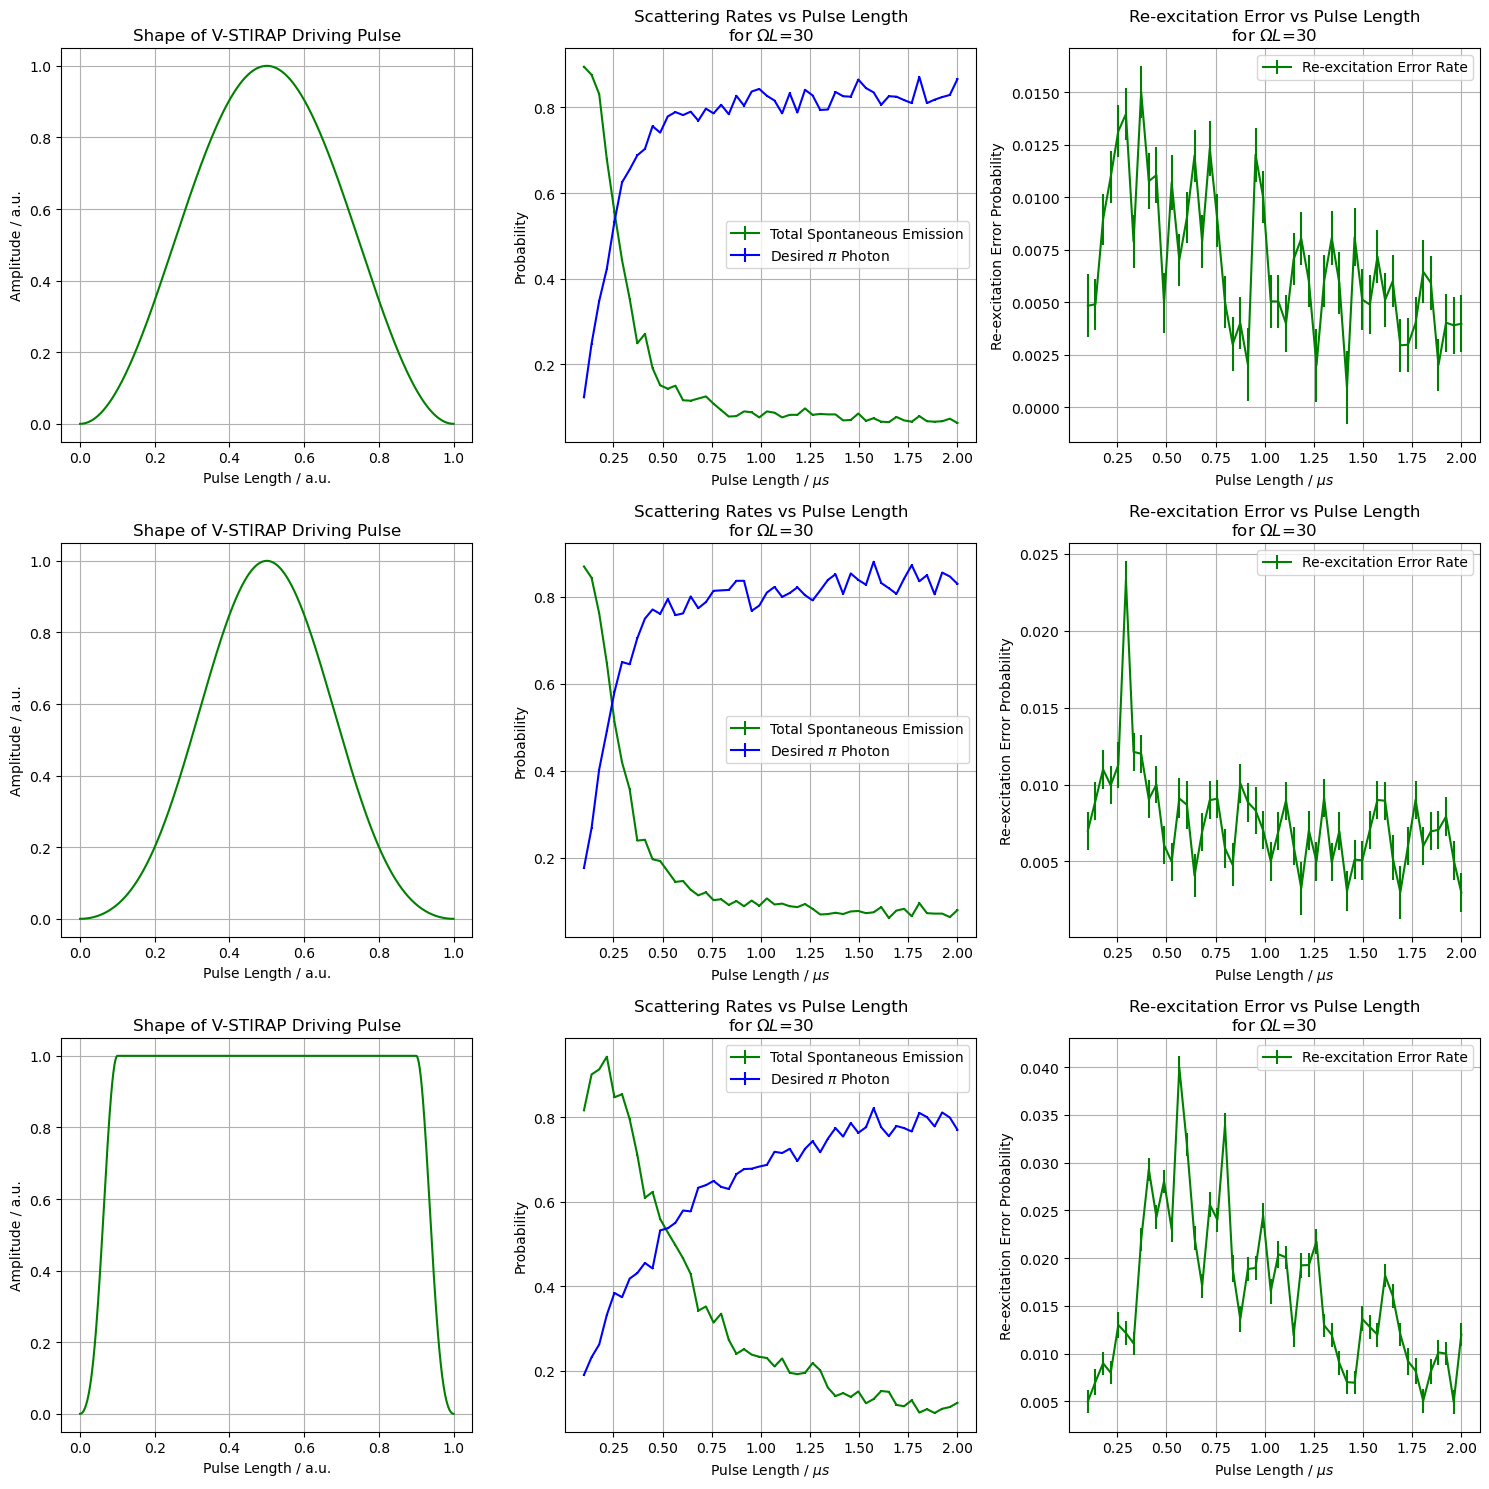

In [19]:
# Dataset file paths and omegaL values for labeling
datasets = [
    ("vstirap_length_rate/mc/pulse_shape_sinsquared_fine_lensweep_omegaL:30.0.pkl", "30"),
    ("vstirap_length_rate/mc/pulse_shape_blackman_fine_lensweep_omegaL:30.0.pkl", "30"),
    ("vstirap_length_rate/mc/pulse_shape_flattop_blackman_fine_lensweep_omegaL:30.0.pkl", "30")
]

# Create 3x3 grid for subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over datasets and rows
for i, (file_path, omegaL_str) in enumerate(datasets):
    data = analyze_stirap_data(file_path, len_list)
    plot_stirap_analysis(axs[i], data, len_list, pulse_time, pulse_shapes[i][0], omegaL_str)

plt.tight_layout()
plt.show()